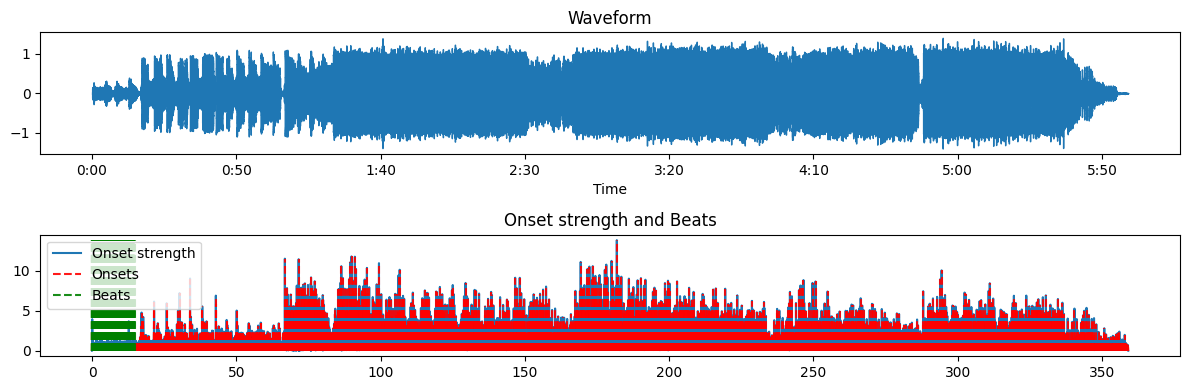

In [5]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Load the audio file
audio_file = 'music.mp3'
y, sr = librosa.load(audio_file)

# Get the onset envelope
onset_env = librosa.onset.onset_strength(y=y, sr=sr)

# Get the beats using the onset envelope
tempo, beats = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr)

# Plot the waveform and the beats
plt.figure(figsize=(12, 4))
plt.subplot(2, 1, 1)
librosa.display.waveshow(y, sr=sr)
plt.title('Waveform')

plt.subplot(2, 1, 2)
plt.plot(librosa.times_like(onset_env), onset_env, label='Onset strength')
plt.vlines(librosa.times_like(onset_env), 0, onset_env, color='r', alpha=0.9, linestyle='--', label='Onsets')
plt.vlines(librosa.times_like(beats), 0, onset_env.max(), color='g', alpha=0.9, linestyle='--', label='Beats')
plt.title('Onset strength and Beats')
plt.legend()

plt.tight_layout()
plt.show()


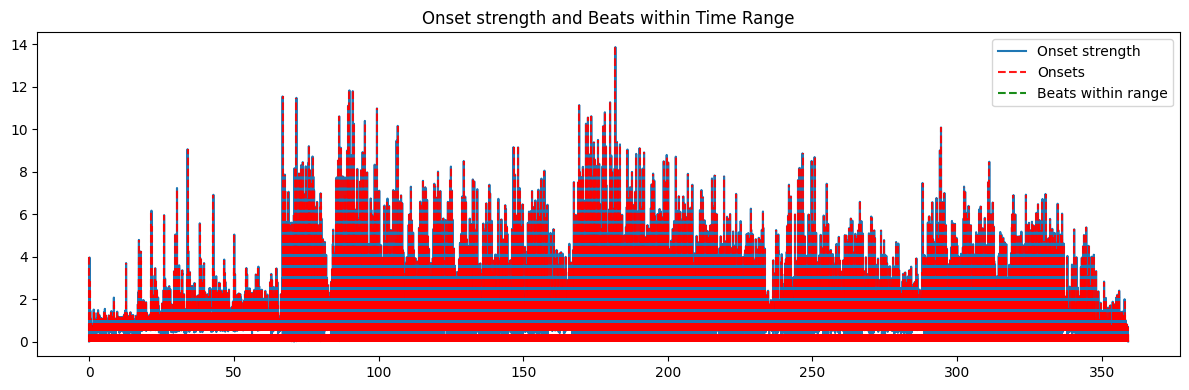

In [8]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Load the audio file
audio_file = 'music.mp3'
y, sr = librosa.load(audio_file)

# Get the onset envelope
onset_env = librosa.onset.onset_strength(y=y, sr=sr)

# Get the beats using the onset envelope
tempo, beats = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr)

# Specify the time range
start_time = 57  # Start time in seconds
end_time = 87    # End time in seconds

# Find the indices of beats within the specified time range
start_frame = int(start_time * sr)
end_frame = int(end_time * sr)
beats_within_range = beats[(beats >= start_frame) & (beats <= end_frame)]

# Convert frame indices to time values
beats_within_range_time = librosa.frames_to_time(beats_within_range, sr=sr)

# Plot only the beats within the specified time range
plt.figure(figsize=(12, 4))
plt.plot(librosa.times_like(onset_env), onset_env, label='Onset strength')
plt.vlines(librosa.times_like(onset_env), 0, onset_env, color='r', alpha=0.9, linestyle='--', label='Onsets')
plt.vlines(beats_within_range_time, 0, onset_env.max(), color='g', alpha=0.9, linestyle='--', label='Beats within range')
plt.title('Onset strength and Beats within Time Range')
plt.legend()

plt.tight_layout()
plt.show()


In [15]:
import os
import librosa
from moviepy.editor import ImageSequenceClip, AudioFileClip

# Load the audio file
audio_file = 'music.mp3'
y, sr = librosa.load(audio_file)

# Duration and start time for the desired portion
desired_duration = 30  # in seconds
start_time = 57  # in seconds

# Trim the audio to the desired portion
start_frame = int(start_time * sr)
end_frame = start_frame + int(desired_duration * sr)
trimmed_audio = y[start_frame:end_frame]

# Path to the folder containing images
images_folder = 'images'

# Get a list of image files in the folder
image_files = [f for f in os.listdir(images_folder) if f.endswith(('.jpg', '.png', '.jpeg'))]

# Full paths to the images
image_paths = [os.path.join(images_folder, image_file) for image_file in image_files]

# Create ImageSequenceClip directly with crossfade transition
video_clip = ImageSequenceClip(image_paths, fps=1)
video_clip = video_clip.crossfadein(1)  # Add a crossfade transition at the beginning

# Set the audio for the video clip
video_clip = video_clip.set_audio(AudioFileClip(audio_file).subclip(start_time, start_time + desired_duration))

# Export the video
output_file = 'output_video.mp4'
video_clip.write_videofile(output_file, codec='libx264', audio_codec='aac', fps=24)


Moviepy - Building video output_video.mp4.
MoviePy - Writing audio in output_videoTEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video output_video.mp4



Moviepy - Done !
Moviepy - video ready output_video.mp4


In [19]:
import os
import librosa
import av
import numpy as np
from pydub import AudioSegment

# Load the audio file
audio_file = 'music.mp3'
y, sr = librosa.load(audio_file)

# Get the beats using the onset envelope
tempo, beats = librosa.beat.beat_track(y=y, sr=sr)

# Total number of images and duration of the video
total_images = 328
desired_duration = 30  # in seconds

# Calculate the duration per image
image_duration = desired_duration / total_images

# Path to the folder containing images
images_folder = 'images'

# Get a list of image files in the folder
image_files = [f for f in os.listdir(images_folder) if f.endswith(('.jpg', '.png', '.jpeg'))]

# Full paths to the images
image_paths = [os.path.join(images_folder, image_file) for image_file in image_files]

# Create a list of image frames synchronized with beats
image_frames = []
for beat_frame in beats:
    # Calculate the index of the image corresponding to the beat frame
    image_index = int(beat_frame % total_images)

    # Load the image frame as a NumPy array
    image_np = np.array(ImageSequenceClip([image_paths[image_index]], fps=1).get_frame(0))

    # Append the image frame to the list
    image_frames.append(image_np)

# Create AudioSegment for the audio with fade-in effect
start_time = 57  # in seconds
audio_clip = AudioSegment.from_file(audio_file).set_frame_rate(sr)
audio_clip = audio_clip[start_time * 1000:].fade_in(2000)  # 2000 milliseconds fade-in

# Create a pyAV VideoContainer
video_container = av.open('output_video.mp4', mode='w', format='mp4')

# Create a video stream with RGB24 format
video_stream = video_container.add_stream('libx264', rate=24)
video_stream.pix_fmt = 'rgb24'
video_stream.width = image_frames[0].shape[1]
video_stream.height = image_frames[0].shape[0]

# Create a audio stream
audio_stream = video_container.add_stream('aac')

# Write video frames to the container
for image_frame in image_frames:
    image_frame_rgb = cv2.cvtColor(image_frame, cv2.COLOR_BGR2RGB)
    video_frame = av.VideoFrame.from_ndarray(image_frame_rgb, format='rgb24')
    video_packet = video_stream.encode(video_frame)
    video_container.mux(video_packet)

# Convert audio_clip to numpy array
audio_frames = np.array(audio_clip.get_array_of_samples())
audio_frame = av.AudioFrame.from_ndarray(audio_frames, format='s16', layout='stereo', rate=sr)

# Write audio frames to the container
audio_packet = audio_stream.encode(audio_frame)
video_container.mux(audio_packet)

# Close the container
video_container.close()


FileNotFoundError: [WinError 2] The system cannot find the file specified

In [20]:
import os
import librosa
from moviepy.editor import ImageSequenceClip, AudioFileClip

# Load the audio file
audio_file = 'music.mp3'
y, sr = librosa.load(audio_file)

# Get the beats using the onset envelope
tempo, beats = librosa.beat.beat_track(y=y, sr=sr)

# Total number of images and duration of the video
total_images = 328
desired_duration = 30  # in seconds

# Calculate the duration per image
image_duration = desired_duration / total_images

# Path to the folder containing images
images_folder = 'images'

# Get a list of image files in the folder
image_files = [f for f in os.listdir(images_folder) if f.endswith(('.jpg', '.png', '.jpeg'))]

# Full paths to the images
image_paths = [os.path.join(images_folder, image_file) for image_file in image_files]

# Create a list of image frames synchronized with beats
image_frames = []
for beat_frame in beats:
    # Calculate the index of the image corresponding to the beat frame
    image_index = int(beat_frame % total_images)
    
    # Load the image frame as a NumPy array
    image_np = ImageSequenceClip([image_paths[image_index]], fps=1).get_frame(0)
    
    # Append the image frame to the list
    image_frames.append(image_np)

# Create ImageSequenceClip with crossfade transitions
video_clip = ImageSequenceClip(image_frames, fps=1)
video_clip = video_clip.crossfadein(1)  # Add a crossfade transition at the beginning

# Set the audio for the video clip
video_clip = video_clip.set_audio(AudioFileClip(audio_file).subclip(0, desired_duration))

# Export the video
output_file = 'output_video.mp4'
video_clip.write_videofile(output_file, codec='libx264', audio_codec='aac', fps=24)


Moviepy - Building video output_video.mp4.
MoviePy - Writing audio in output_videoTEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video output_video.mp4



Moviepy - Done !
Moviepy - video ready output_video.mp4


In [3]:
import os
import librosa
from moviepy.editor import ImageSequenceClip, AudioFileClip
import numpy as np
# Load the audio file
audio_file = 'music.mp3'
y, sr = librosa.load(audio_file)

# Get the beats using the onset envelope
tempo, beats = librosa.beat.beat_track(y=y, sr=sr)

# Total number of images and desired duration of the video
total_images = 328
desired_duration = 30  # in seconds

# Calculate the frames per beat based on the tempo
frames_per_beat = int(sr * 60 / tempo)

# Path to the folder containing images
images_folder = 'images'

# Get a list of image files in the folder
image_files = [f for f in os.listdir(images_folder) if f.endswith(('.jpg', '.png', '.jpeg'))]

# Full paths to the images
image_paths = [os.path.join(images_folder, image_file) for image_file in image_files]
from PIL import Image

# ...

# Create a list of image frames synchronized with beats and within the desired duration
image_frames = []
for beat_frame in beats:
    # Calculate the index of the image corresponding to the beat frame
    image_index = int(beat_frame % total_images)

       # Load and resize the image
    image_path = image_paths[image_index]
    img = Image.open(image_path)
    img = img.resize((800, 600))  # Adjust the size as needed

    # Convert the image to a NumPy array
    image_np = np.array(img)

    # Append the image frame to the list
        # Check if the total duration exceeds the desired duration
    if len(image_frames) * (1 / frames_per_beat) >= desired_duration:
        break
    else:
        # Append the image frame to the list
        image_frames.append(image_np)


# Create ImageSequenceClip with crossfade transitions
video_clip = ImageSequenceClip(image_frames, fps=frames_per_beat)
video_clip = video_clip.crossfadein(1)  # Add a crossfade transition at the beginning

# Set the audio for the video clip
# Set the audio for the video clip
video_clip = video_clip.set_audio(AudioFileClip(audio_file).subclip(57, 57 + desired_duration))

# Export the video
output_file = 'output_video.mp4'
video_clip.write_videofile(output_file, codec='libx264', audio_codec='aac', fps=24)


Moviepy - Building video output_video.mp4.
MoviePy - Writing audio in output_videoTEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video output_video.mp4



Moviepy - Done !
Moviepy - video ready output_video.mp4


### basic ass cute thing

In [7]:
# Load audio and get beats
audio_file = 'music.mp3' 
y, sr = librosa.load(audio_file)
tempo, beats = librosa.beat.beat_track(y=y, sr=sr)

# Parameters
total_images = 328 
desired_duration = 30 # seconds
fps = 24 

# Calculate frames per beat 
frames_per_beat = int(sr * 60 / tempo)

# Generate video frames
image_frames = []
for i, beat in enumerate(beats):
  if len(image_frames) >= desired_duration * fps: 
    break
  
  image_idx = i % total_images
  image_path = image_paths[image_idx]
  
  img = Image.open(image_path)
  img = img.resize((800, 600))
  
  image_frames.append(np.array(img))

# Create and export video 
clip = ImageSequenceClip(image_frames, fps=fps)
clip = clip.set_duration(desired_duration)
clip = clip.set_audio(AudioFileClip(audio_file)) 
clip.write_videofile('output.mp4', codec='libx264', audio_codec='aac')

Moviepy - Building video output.mp4.
MoviePy - Writing audio in outputTEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video output.mp4



Moviepy - Done !
Moviepy - video ready output.mp4


In [15]:
import os
import librosa
from moviepy.editor import ImageSequenceClip, AudioFileClip
import numpy as np
from PIL import Image

# Load the audio file
audio_file = 'music.mp3'
y, sr = librosa.load(audio_file)

# Get the beats using the onset envelope
tempo, beats = librosa.beat.beat_track(y=y, sr=sr)

# Total number of images and desired duration of the video
total_images = 328
desired_duration = 30  # in seconds

# Calculate the frames per beat based on the tempo
frames_per_beat = int(sr * 60 / tempo)

# Path to the folder containing images
images_folder = 'images'

# Get a list of image files in the folder
image_files = [f for f in os.listdir(images_folder) if f.endswith(('.jpg', '.png', '.jpeg'))]

# Full paths to the images
image_paths = [os.path.join(images_folder, image_file) for image_file in image_files]

# Create a list of image frames synchronized with beats and within the desired duration
image_frames = []
for beat_frame in beats:
    # Calculate the index of the image corresponding to the beat frame
    image_index = int(beat_frame % total_images)

    # Load and resize the image
    image_path = image_paths[image_index]
    img = Image.open(image_path)
    img = img.resize((1500, 2000))  # Set the desired size

    # Convert the image to a NumPy array
    image_np = np.array(img)

    # Check if the total duration exceeds the desired duration
    if len(image_frames) * (1 / frames_per_beat) >= desired_duration:
        break
    else:
        # Append the image frame to the list
        image_frames.append(image_np)

# Create ImageSequenceClip with crossfade transitions
video_clip = ImageSequenceClip(image_frames, fps=frames_per_beat)
video_clip = video_clip.crossfadein(1)  # Add a crossfade transition at the beginning

# Set the audio for the video clip
video_clip = video_clip.set_audio(AudioFileClip(audio_file).subclip(67, 67 + desired_duration))

# Export the video
output_file = 'output_videoFR.mp4'
video_clip.write_videofile(output_file, codec='libx264', audio_codec='aac', fps=24)


Moviepy - Building video output_videoFR.mp4.
MoviePy - Writing audio in output_videoFRTEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video output_videoFR.mp4



Moviepy - Done !
Moviepy - video ready output_videoFR.mp4


In [16]:
## uppar wala chal raha

In [2]:
import os
import librosa
from moviepy.editor import ImageSequenceClip, AudioFileClip
import numpy as np
from PIL import Image

# Load the audio file
audio_file = 'music.mp3'
y, sr = librosa.load(audio_file)

# Get the beats using the onset envelope
tempo, beats = librosa.beat.beat_track(y=y, sr=sr)

# Total number of images and desired duration of the video
total_images = 328
desired_duration = 30  # in seconds

# Path to the folder containing images
images_folder = 'images'

# Get a list of image files in the folder
image_files = [f for f in os.listdir(images_folder) if f.endswith(('.jpg', '.png', '.jpeg'))]

# Full paths to the images
image_paths = [os.path.join(images_folder, image_file) for image_file in image_files]

# Create a list of image frames synchronized with beats and within the desired duration
image_frames = []
beat_duration = 60 / tempo  # duration of one beat in seconds

for beat_time in range(int(desired_duration / beat_duration)):
    # Calculate the index of the image corresponding to the current beat
    image_index = int((beat_time * total_images / (desired_duration / beat_duration)) % total_images)

    # Load and resize the image
    image_path = image_paths[image_index]
    img = Image.open(image_path)
    img = img.resize((1500, 2000)) 

    # Convert the image to a NumPy array
    image_np = np.array(img)

    # Append the image frame to the list
    image_frames.append(image_np)

# Create ImageSequenceClip with crossfade transitions
fps = len(image_frames) / desired_duration
video_clip = ImageSequenceClip(image_frames, fps=fps)
video_clip = video_clip.crossfadein(1)  # Add a crossfade transition at the beginning

# Set the audio for the video clip
video_clip = video_clip.set_audio(AudioFileClip(audio_file).subclip(67, 67 + desired_duration))

# Export the video
output_file = 'output_videoFR.mp4'
video_clip.write_videofile(output_file, codec='libx264', audio_codec='aac', fps=fps)


Moviepy - Building video output_videoFR.mp4.
MoviePy - Writing audio in output_videoFRTEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video output_videoFR.mp4



Moviepy - Done !
Moviepy - video ready output_videoFR.mp4


### WORKING BUT SLOW UPPAR

In [5]:
import os
import librosa
from moviepy.editor import ImageSequenceClip, AudioFileClip
import numpy as np
from PIL import Image

# Load the audio file
audio_file = 'music.mp3'
y, sr = librosa.load(audio_file)

# Get the beats using the onset envelope
tempo, beats = librosa.beat.beat_track(y=y, sr=sr)

# Total number of images and desired duration of the video
total_images = 328
desired_duration = 30  # in seconds

# Path to the folder containing images
images_folder = 'images'

# Get a list of image files in the folder
image_files = [f for f in os.listdir(images_folder) if f.endswith(('.jpg', '.png', '.jpeg'))]

# Full paths to the images
image_paths = [os.path.join(images_folder, image_file) for image_file in image_files]

# Calculate the duration of one beat in seconds
beat_duration = 60 / tempo

# Create a list of image frames synchronized with beats and within the desired duration
image_frames = []

# Iterate over the beats
for beat in beats:
    # Calculate the index of the image corresponding to the current beat
    image_index = int((beat * total_images) % total_images)

    # Load and resize the image
    image_path = image_paths[image_index]
    img = Image.open(image_path)
    img = img.resize((1500, 2000))  # Set the desired size

    # Convert the image to a NumPy array
    image_np = np.array(img)

    # Append the image frame to the list
    image_frames.append(image_np)

# Create ImageSequenceClip with crossfade transitions
fps = len(image_frames) / desired_duration
video_clip = ImageSequenceClip(image_frames, fps=fps)
video_clip = video_clip.crossfadein(1)  # Add a crossfade transition at the beginning

# Set the audio for the video clip
video_clip = video_clip.set_audio(AudioFileClip(audio_file).subclip(57, 57 + desired_duration))

# Export the video
output_file = 'output_video.mp4'
video_clip.write_videofile(output_file, codec='libx264', audio_codec='aac', fps=fps)


t:  24%|███████████████▌                                                 | 1889/7872 [02:48<03:36, 27.63it/s, now=None]

Moviepy - Building video output_video.mp4.
MoviePy - Writing audio in output_videoTEMP_MPY_wvf_snd.mp4



t:  24%|███████████████▌                                                 | 1889/7872 [02:48<03:36, 27.63it/s, now=None]

MoviePy - Done.
Moviepy - Writing video output_video.mp4




t:  61%|█████████████████████████████████████████                          | 389/635 [00:15<00:09, 26.38it/s, now=None]


t:  24%|███████████████▌                                                 | 1889/7872 [03:14<03:36, 27.63it/s, now=None]

Moviepy - Done !
Moviepy - video ready output_video.mp4


In [9]:
import librosa
import numpy as np
from scipy.signal import find_peaks

# Load the audio file
audio_file = 'music.mp3'
y, sr = librosa.load(audio_file)

# Set a threshold for highs (adjust as needed)
threshold = 0.6

# Extract highs for a specific duration (e.g., 10 seconds from the 57th second)
start_time = 57  # in seconds
duration = 30  # in seconds

# Convert time to frames
start_frame = int(start_time * sr)
end_frame = start_frame + int(duration * sr)

# Extract highs only for the specified duration
highs, _ = librosa.effects.hpss(y[start_frame:end_frame])
highs_peaks, _ = find_peaks(highs, height=threshold)

# Display the first 300 peaks
print("Highs Peaks:", highs_peaks[:300])


Highs Peaks: [217411 217421 217426 217430 218550 218555 218564 218566 218573 218580
 218591 218598 218601 218603 218628 219590 219601 219624 220292 221026
 221032 221037 221377 221736 221741 222438 222448 223920 224275 225352
 225678 225702 225704 226056 226063 226416 226766 227465 227490 227827
 228211 229263 229625 230403 230405 232516 232873 233211 233563 233589
 233921 233939 234289 234302 234310 235375 235724 236078 236501 237215
 240369 240729 249362 249709 250826 251188 256162 256866 256876 257251
 257954 316022 585560 585563 585565 585881 585886 585909 585916 585940
 585945 585974 586731 586754 586790 587201 588606 588990 589665 589689
 589724 590016 590077 590431 591136 591460 592550 593199 593614 593982
 593986 594327 594674 595027 596750 597050 597075 597080 597085 597115
 597380 597404 597407 597409 597425 597462 597827 597832 597838 597849
 597854 597858 597863 598212 598215 598238 599288 602569 602832 602838
 603194 603283 604983 605339 608555 608562 608574 608581 608586 

In [10]:
# Total number of images and desired duration of the video
total_images = 328
desired_duration = 30  # in seconds

# Path to the folder containing images
images_folder = 'images'

# Get a list of image files in the folder
image_files = [f for f in os.listdir(images_folder) if f.endswith(('.jpg', '.png', '.jpeg'))]

# Full paths to the images
image_paths = [os.path.join(images_folder, image_file) for image_file in image_files]

# Create a list of image frames synchronized with highs peaks and within the desired duration
image_frames = []
fps = len(highs_peaks) / duration

for peak_frame in highs_peaks:
    # Calculate the index of the image corresponding to the peak frame
    image_index = int(peak_frame % total_images)

    # Load and resize the image
    image_path = image_paths[image_index]
    img = Image.open(image_path)
    img = img.resize((1500, 2000))  # Set the desired size

    # Convert the image to a NumPy array
    image_np = np.array(img)

    # Append the image frame to the list
    image_frames.append(image_np)

# Create ImageSequenceClip with crossfade transitions
video_clip = ImageSequenceClip(image_frames, fps=fps)
video_clip = video_clip.crossfadein(1)  # Add a crossfade transition at the beginning

# Set the audio for the video clip
video_clip = video_clip.set_audio(AudioFileClip(audio_file).subclip(start_time, start_time + desired_duration))

# Export the video
output_file = 'output_video_highs_synced.mp4'
video_clip.write_videofile(output_file, codec='libx264', audio_codec='aac', fps=fps)

t:  24%|███████████████▌                                                 | 1889/7872 [06:13<03:36, 27.63it/s, now=None]

Moviepy - Building video output_video_highs_synced.mp4.
MoviePy - Writing audio in output_video_highs_syncedTEMP_MPY_wvf_snd.mp4



t:  24%|███████████████▌                                                 | 1889/7872 [06:13<03:36, 27.63it/s, now=None]

MoviePy - Done.
Moviepy - Writing video output_video_highs_synced.mp4




t:  24%|███████████████▌                                                 | 1889/7872 [06:29<03:36, 27.63it/s, now=None]

Moviepy - Done !
Moviepy - video ready output_video_highs_synced.mp4


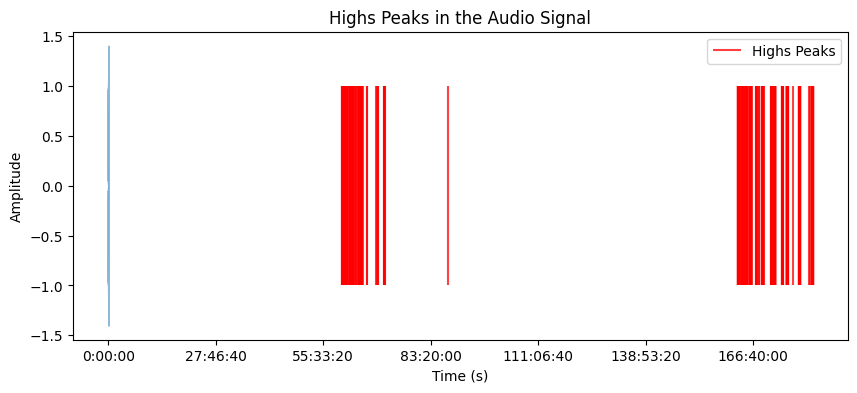

t:  24%|███████████████                                                | 1889/7872 [1:09:10<03:36, 27.63it/s, now=None]

Moviepy - Building video outp_synced.mp4.
MoviePy - Writing audio in outp_syncedTEMP_MPY_wvf_snd.mp4



t:  24%|███████████████                                                | 1889/7872 [1:09:10<03:36, 27.63it/s, now=None]

MoviePy - Done.
Moviepy - Writing video outp_synced.mp4




t:  24%|███████████████                                                | 1889/7872 [1:09:25<03:36, 27.63it/s, now=None]

Moviepy - Done !
Moviepy - video ready outp_synced.mp4


In [11]:
import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from moviepy.editor import ImageSequenceClip, AudioFileClip
from PIL import Image

# Load the audio file
audio_file = 'music.mp3'
y, sr = librosa.load(audio_file)

# Set a threshold for highs (adjust as needed)
threshold = 0.6

# Extract highs for a specific duration (e.g., 10 seconds from the 57th second)
start_time = 67  # in seconds
duration = 30  # in seconds

# Convert time to frames
start_frame = int(start_time * sr)
end_frame = start_frame + int(duration * sr)

# Extract highs only for the specified duration
highs, _ = librosa.effects.hpss(y[start_frame:end_frame])
highs_peaks, _ = find_peaks(highs, height=threshold)

# Plot the highs
plt.figure(figsize=(10, 4))
librosa.display.waveshow(y, sr=sr, alpha=0.5)
plt.vlines(highs_peaks, -1, 1, color='r', alpha=0.75, label='Highs Peaks')
plt.title('Highs Peaks in the Audio Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

# Total number of images and desired duration of the video
total_images = 328

# Path to the folder containing images
images_folder = 'images'

# Get a list of image files in the folder
image_files = [f for f in os.listdir(images_folder) if f.endswith(('.jpg', '.png', '.jpeg'))]

# Full paths to the images
image_paths = [os.path.join(images_folder, image_file) for image_file in image_files]

# Create a list of image frames synchronized with highs peaks and within the desired duration
image_frames = []
fps = len(highs_peaks) / duration

for peak_frame in highs_peaks:
    # Calculate the index of the image corresponding to the peak frame
    image_index = int(peak_frame % total_images)

    # Load and resize the image
    image_path = image_paths[image_index]
    img = Image.open(image_path)
    img = img.resize((1500, 2000))  # Set the desired size

    # Convert the image to a NumPy array
    image_np = np.array(img)

    # Append the image frame to the list
    image_frames.append(image_np)

# Create ImageSequenceClip with crossfade transitions
video_clip = ImageSequenceClip(image_frames, fps=fps)
video_clip = video_clip.crossfadein(1)  # Add a crossfade transition at the beginning

# Set the audio for the video clip
video_clip = video_clip.set_audio(AudioFileClip(audio_file).subclip(start_time, start_time + duration))

# Export the video
output_file = 'outp_synced.mp4'
video_clip.write_videofile(output_file, codec='libx264', audio_codec='aac', fps=fps)


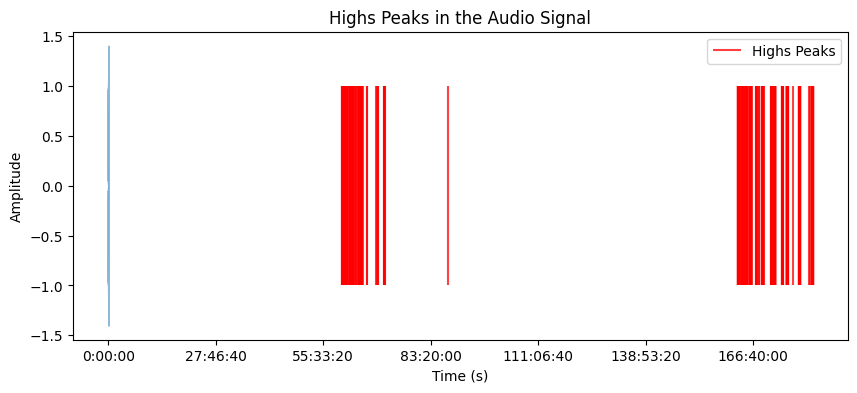

t:  24%|███████████████                                                | 1889/7872 [1:12:56<03:36, 27.63it/s, now=None]

Moviepy - Building video output_video_highs_synced.mp4.
MoviePy - Writing audio in output_video_highs_syncedTEMP_MPY_wvf_snd.mp4



t:  24%|███████████████                                                | 1889/7872 [1:12:57<03:36, 27.63it/s, now=None]

MoviePy - Done.
Moviepy - Writing video output_video_highs_synced.mp4




t:  24%|███████████████                                                | 1889/7872 [1:13:09<03:36, 27.63it/s, now=None]

Moviepy - Done !
Moviepy - video ready output_video_highs_synced.mp4


In [12]:
import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from moviepy.editor import ImageSequenceClip, AudioFileClip
from PIL import Image

# Load the audio file
audio_file = 'music.mp3'
y, sr = librosa.load(audio_file)

# Set a threshold for highs (adjust as needed)
threshold = 0.6

# Extract highs for a specific duration (e.g., 10 seconds from the 57th second)
start_time = 57  # in seconds
duration = 30  # in seconds

# Convert time to frames
start_frame = int(start_time * sr)
end_frame = start_frame + int(duration * sr)

# Extract highs only for the specified duration
highs, _ = librosa.effects.hpss(y[start_frame:end_frame])
highs_peaks, _ = find_peaks(highs, height=threshold)

# Plot the highs
plt.figure(figsize=(10, 4))
librosa.display.waveshow(y, sr=sr, alpha=0.5)
plt.vlines(highs_peaks, -1, 1, color='r', alpha=0.75, label='Highs Peaks')
plt.title('Highs Peaks in the Audio Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

# Total number of images and desired duration of the video
total_images = 328

# Path to the folder containing images
images_folder = 'images'

# Get a list of image files in the folder
image_files = [f for f in os.listdir(images_folder) if f.endswith(('.jpg', '.png', '.jpeg'))]

# Full paths to the images
image_paths = [os.path.join(images_folder, image_file) for image_file in image_files]

# Create a list of image frames synchronized with highs peaks and within the desired duration
image_frames = []
fps = len(highs_peaks) / duration

for peak_frame in highs_peaks:
    # Calculate the index of the image corresponding to the peak frame
    image_index = int((peak_frame * total_images) / len(y))

    # Load and resize the image
    image_path = image_paths[image_index]
    img = Image.open(image_path)
    img = img.resize((1500, 2000))  # Set the desired size

    # Convert the image to a NumPy array
    image_np = np.array(img)

    # Append the image frame to the list
    image_frames.append(image_np)
     
# Create ImageSequenceClip with crossfade transitions
video_clip = ImageSequenceClip(image_frames, fps=fps)
video_clip = video_clip.crossfadein(1)  # Add a crossfade transition at the beginning

# Set the audio for the video clip
video_clip = video_clip.set_audio(AudioFileClip(audio_file).subclip(start_time, start_time + duration))

# Export the video
output_file = 'output_video_highs_synced.mp4'
video_clip.write_videofile(output_file, codec='libx264', audio_codec='aac', fps=fps)


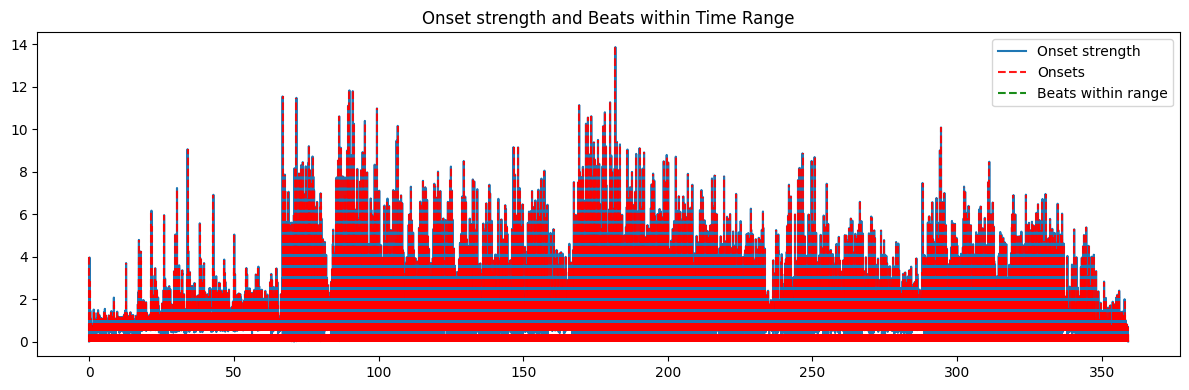

In [17]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Load the audio file
audio_file = 'music.mp3'
y, sr = librosa.load(audio_file)

# Get the onset envelope
onset_env = librosa.onset.onset_strength(y=y, sr=sr)

# Get the beats using the onset envelope
tempo, beats = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr)

# Specify the time range
start_time = 57  # Start time in seconds
end_time = 87    # End time in seconds

# Find the indices of beats within the specified time range
start_frame = int(start_time * sr)
end_frame = int(end_time * sr)
beats_within_range = beats[(beats >= start_frame) & (beats <= end_frame)]

# Convert frame indices to time values
beats_within_range_time = librosa.frames_to_time(beats_within_range, sr=sr)

# Plot only the beats within the specified time range
plt.figure(figsize=(12, 4))
plt.plot(librosa.times_like(onset_env), onset_env, label='Onset strength')
plt.vlines(librosa.times_like(onset_env), 0, onset_env, color='r', alpha=0.9, linestyle='--', label='Onsets')
plt.vlines(beats_within_range_time, 0, onset_env.max(), color='g', alpha=0.9, linestyle='--', label='Beats within range')
plt.title('Onset strength and Beats within Time Range')
plt.legend()

plt.tight_layout()
plt.show()


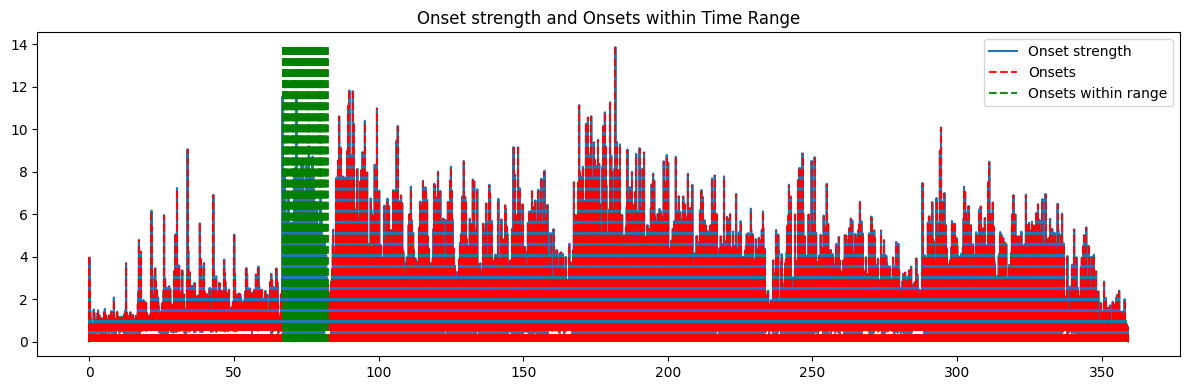

Onset Times within Range: [66.82702948 67.12888889 67.33786848 67.4307483  67.57006803 67.70938776
 67.91836735 68.10412698 68.33632653 68.61496599 68.87038549 69.12580499
 69.40444444 69.65986395 69.9385034  70.1939229  70.42612245 70.47256236
 70.7047619  70.93696145 71.02984127 71.35492063 71.4245805  71.51746032
 71.61034014 71.72643991 71.88897959 72.07473923 72.21405896 72.49269841
 72.74811791 73.00353741 73.25895692 73.53759637 73.79301587 74.04843537
 74.32707483 74.55927438 74.83791383 75.09333333 75.20943311 75.60417234
 75.6738322  75.78993197 75.90603175 76.04535147 76.23111111 76.4400907
 76.67229025 76.92770975 77.18312925 77.43854875 77.71718821 77.97260771
 78.22802721 78.48344671 78.73886621 79.01750567 79.27292517 79.36580499
 79.4122449  79.64444444 79.78376417 79.85342404 79.94630385 80.08562358
 80.22494331 80.41070295 80.61968254 80.87510204 81.10730159 81.36272109
 81.64136054 81.89678005 82.15219955 82.430839  ]
Number of Onsets within Range: 76


In [41]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Load the audio file
audio_file = 'music.mp3'
y, sr = librosa.load(audio_file)

# Get the onset envelope
onset_env = librosa.onset.onset_strength(y=y, sr=sr)

# Get the beats using the onset envelope
tempo, beats = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr)

# Specify the time range
start_time = 66  # Start time in seconds (1:06)
end_time = 83    # End time in seconds (1:23)

# Find the onsets within the specified time range
onsets = librosa.onset.onset_detect(onset_envelope=onset_env, sr=sr)

# Filter onsets within the specified time range
onsets_within_range = [onset for onset in onsets if start_time <= librosa.frames_to_time(onset, sr=sr) <= end_time]

# Convert frame indices to time values
onsets_within_range_time = librosa.frames_to_time(onsets_within_range, sr=sr)

# Plot the onset envelope and onsets within the specified time range
plt.figure(figsize=(12, 4))
plt.plot(librosa.times_like(onset_env), onset_env, label='Onset strength')
plt.vlines(librosa.times_like(onset_env), 0, onset_env, color='r', alpha=0.9, linestyle='--', label='Onsets')
plt.vlines(onsets_within_range_time, 0, onset_env.max(), color='g', alpha=0.9, linestyle='--', label='Onsets within range')
plt.title('Onset strength and Onsets within Time Range')
plt.legend()

plt.tight_layout()
plt.show()

# Print the onset times within the specified time range
print("Onset Times within Range:", onsets_within_range_time)
print("Number of Onsets within Range:", len(onsets_within_range_time))


In [42]:
import os
from moviepy.editor import ImageSequenceClip, AudioFileClip

# Path to the folder containing images
images_folder = 'images'

# Get a list of image files in the folder
image_files = [f for f in os.listdir(images_folder) if f.endswith(('.jpg', '.png', '.jpeg'))]

# Full paths to the images
image_paths = [os.path.join(images_folder, image_file) for image_file in image_files]

# Load the audio file
audio_file = 'music.mp3'

# Specify the time range
start_time = 66  # Start time in seconds (1:06)
end_time = 83    # End time in seconds (1:23)

# Create a list of image frames synchronized with onset times within the specified range
image_frames = []

for onset_time in onsets_within_range_time:
    # Calculate the index of the image corresponding to the onset time
    image_index = int((onset_time - start_time) / (end_time - start_time) * len(image_paths))

    # Load the image and convert it to a NumPy array
    image_path = image_paths[image_index]
    img = Image.open(image_path)
    img_np = np.array(img)

    # Append the image frame to the list
    image_frames.append(img_np)

# Create ImageSequenceClip with crossfade transitions
fps = len(image_frames) / (end_time - start_time)
video_clip = ImageSequenceClip(image_frames, fps=fps)
video_clip = video_clip.crossfadein(1)  # Add a crossfade transition at the beginning

# Set the audio for the video clip
video_clip = video_clip.set_audio(AudioFileClip(audio_file).subclip(start_time, end_time))

# Export the video
output_file = 'output_video_onsets.mp4'
video_clip.write_videofile(output_file, codec='libx264', audio_codec='aac', fps=24)


Moviepy - Building video output_video_onsets.mp4.
MoviePy - Writing audio in output_video_onsetsTEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video output_video_onsets.mp4



Moviepy - Done !
Moviepy - video ready output_video_onsets.mp4


In [30]:
print("Number of Images Displayed:", len(onsets_within_range_time))


Number of Images Displayed: 76


In [31]:
desired_duration = 17  # in seconds
total_images = 328

# Calculate the frame rate
frame_rate = total_images / desired_duration

print("Required Frame Rate:", frame_rate)


Required Frame Rate: 19.294117647058822


In [47]:
import os
from moviepy.editor import ImageSequenceClip, AudioFileClip
import numpy as np
from PIL import Image

# Path to the folder containing images
images_folder = 'images'

# Get a list of image files in the folder
image_files = [f for f in os.listdir(images_folder) if f.endswith(('.jpg', '.png', '.jpeg'))]

# Full paths to the images
image_paths = [os.path.join(images_folder, image_file) for image_file in image_files]

# Total number of images
total_images = 328

# Specify the time range
start_time = 66  # Start time in seconds (1:06)
end_time = 83    # End time in seconds (1:23)

# Calculate the frame rate
fps = total_images / (end_time - start_time)

# Create a list of image frames synchronized with the time range
image_frames = []

for image_path in image_paths:
    # Load the image and convert it to a NumPy array
    img = Image.open(image_path)
    img_np = np.array(img)

    # Append the image frame to the list
    image_frames.append(img_np)

# Create ImageSequenceClip with crossfade transitions
video_clip = ImageSequenceClip(image_frames, fps=fps)
video_clip = video_clip.crossfadein(1)  # Add a crossfade transition at the beginning

# Set the audio for the video clip
audio_file = 'music.mp3'
video_clip = video_clip.set_audio(AudioFileClip(audio_file).subclip(start_time, end_time))

# Export the video
output_file = 'output_video_328images.mp4'
video_clip.write_videofile(output_file, codec='libx264', audio_codec='aac', fps=fps)


Moviepy - Building video output_video_328images.mp4.
MoviePy - Writing audio in output_video_328imagesTEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video output_video_328images.mp4



Moviepy - Done !
Moviepy - video ready output_video_328images.mp4


In [48]:
print("Number of Images Displayed:", len(onsets_within_range_time))


Number of Images Displayed: 76


In [5]:
import os
from moviepy.editor import ImageSequenceClip, AudioFileClip
import numpy as np
from PIL import Image
import librosa

# Load the audio file
audio_file = 'music.mp3'
y, sr = librosa.load(audio_file)

# Get the onset envelope
onset_env = librosa.onset.onset_strength(y=y, sr=sr)

# Manually set a threshold for peak detection
threshold = 0.6
peaks = (onset_env > threshold).astype(int)

# Find the indices of the peaks
peak_indices = np.nonzero(peaks)[0]

# Total number of images and desired duration of the video
total_images = 328
desired_duration = 30  # in seconds

# Path to the folder containing images
images_folder = 'images'

# Get a list of image files in the folder
image_files = [f for f in os.listdir(images_folder) if f.endswith(('.jpg', '.png', '.jpeg'))]

# Full paths to the images
image_paths = [os.path.join(images_folder, image_file) for image_file in image_files]

# Create a list of image frames synchronized with peaks
image_frames = []

# Specify the start time
start_time = '00:01:06.20'

# Convert start_time to seconds
start_time_seconds = sum(x * float(t) for x, t in zip([3600, 60, 1], start_time.split(':')))

for i in range(int(desired_duration / 0.05)):
    # Calculate the time for the current frame
    current_time = start_time_seconds + i * 0.05
    
    # Find the nearest peak index for the current time
    nearest_peak_index = np.argmin(np.abs(librosa.frames_to_time(peak_indices, sr=sr) - current_time))
    
    # Calculate the index of the image corresponding to the nearest peak
    image_index = int((peak_indices[nearest_peak_index] / len(onset_env)) * total_images) % total_images

    # Load the image, resize, and convert it to a NumPy array
    image_path = image_paths[image_index]
    img = Image.open(image_path)
    img = img.resize((1500, 2000))  # Resize the image to reduce memory usage
    img_np = np.array(img)

    # Append the image frame to the list
    image_frames.append(img_np)

# Create ImageSequenceClip with crossfade transitions
fps = len(image_frames) / desired_duration
video_clip = ImageSequenceClip(image_frames, fps=fps)
video_clip = video_clip.crossfadein(1)  # Add a crossfade transition at the beginning

# Set the audio for the video clip
video_clip = video_clip.set_audio(AudioFileClip(audio_file).subclip(start_time_seconds, start_time_seconds + desired_duration))

# Export the video
output_file = 'output_video_frames_at_intervals.mp4'
video_clip.write_videofile(output_file, codec='libx264', audio_codec='aac', fps=24)


Moviepy - Building video output_video_frames_at_intervals.mp4.
MoviePy - Writing audio in output_video_frames_at_intervalsTEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video output_video_frames_at_intervals.mp4



Moviepy - Done !
Moviepy - video ready output_video_frames_at_intervals.mp4


In [17]:
import os
import numpy as np
from PIL import Image
from moviepy.editor import ImageSequenceClip, AudioFileClip

# Path to the folder containing images
images_folder = 'images'

# Get a list of image files in the folder
image_files = [f for f in os.listdir(images_folder) if f.endswith(('.jpg', '.png', '.jpeg'))]

# Full paths to the images
image_paths = [os.path.join(images_folder, image_file) for image_file in image_files]

# Load the audio file
audio_file = 'music1.mp3'

# Total number of images and desired duration of the video
total_images = 328
desired_duration = 17  # in seconds

# Calculate the frames per second
fps = total_images / desired_duration

# Create a list of image frames synchronized with the duration
image_frames = []

# Calculate the time interval between frames
time_interval = desired_duration / total_images

# Load and resize images for each time interval
for i in range(total_images):
    # Calculate the time for the current frame
    frame_time = i * time_interval
    
    # Calculate the index of the image corresponding to the frame
    image_index = int((frame_time / desired_duration) * total_images)
    
    # Load and resize the image
    image_path = image_paths[image_index]
    img = Image.open(image_path)
    img = img.resize((1500, 2000))  # Resize the image to reduce memory usage
    
    # Convert the image to a NumPy array
    img_np = np.array(img)

    # Append the image frame to the list
    image_frames.append(img_np)

# Create ImageSequenceClip with crossfade transitions
video_clip = ImageSequenceClip(image_frames, fps=fps)
video_clip = video_clip.crossfadein(1)  # Add a crossfade transition at the beginning

# Set the audio for the video clip
video_clip = video_clip.set_audio(AudioFileClip(audio_file).subclip(0, desired_duration))

# Export the video
output_file = 'basicFUll.mp4'
video_clip.write_videofile(output_file, codec='libx264', audio_codec='aac', fps=fps)


chunk:  59%|███████████████████████████████████▉                         | 390/662 [04:38<00:00, 1295.10it/s, now=None]

Moviepy - Building video basicFUll.mp4.
MoviePy - Writing audio in basicFUllTEMP_MPY_wvf_snd.mp4



chunk:  59%|███████████████████████████████████▉                         | 390/662 [04:38<00:00, 1295.10it/s, now=None]

MoviePy - Done.
Moviepy - Writing video basicFUll.mp4




chunk:  59%|███████████████████████████████████▉                         | 390/662 [04:54<00:00, 1295.10it/s, now=None]

Moviepy - Done !
Moviepy - video ready basicFUll.mp4


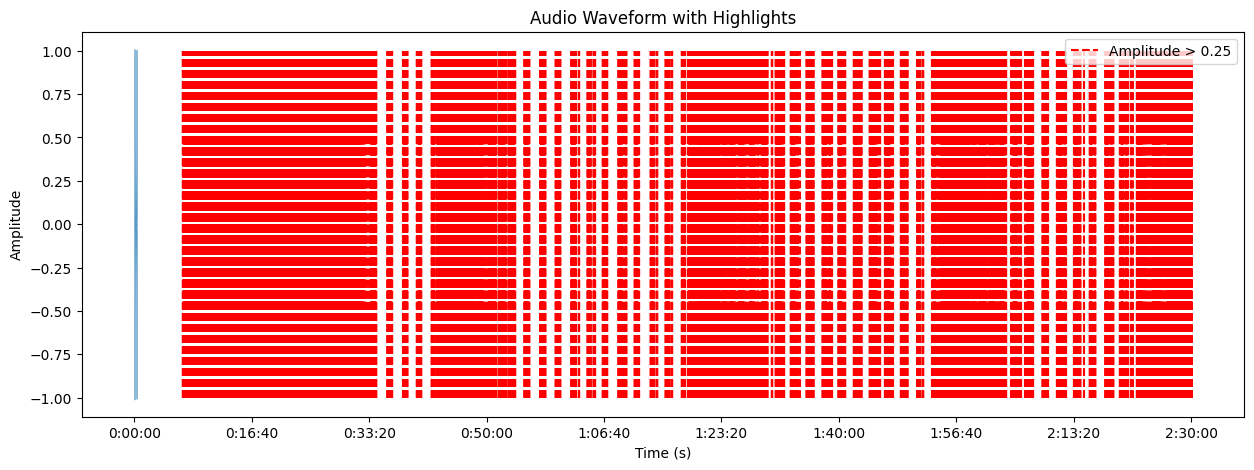

In [18]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

# Load the audio file
audio_file = 'music1.mp3'
y, sr = librosa.load(audio_file)

# Find the timestamps where the amplitude is above 0.25
threshold = 0.25
above_threshold = np.where(y > threshold)[0]
time_above_threshold = librosa.frames_to_time(above_threshold, sr=sr)

# Plot the audio waveform
plt.figure(figsize=(15, 5))
librosa.display.waveshow(y, sr=sr, alpha=0.5)

# Highlight the timestamps above the threshold
plt.vlines(time_above_threshold, ymin=-1, ymax=1, color='r', linestyle='--', label='Amplitude > 0.25')

# Set plot labels and title
plt.title('Audio Waveform with Highlights')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()


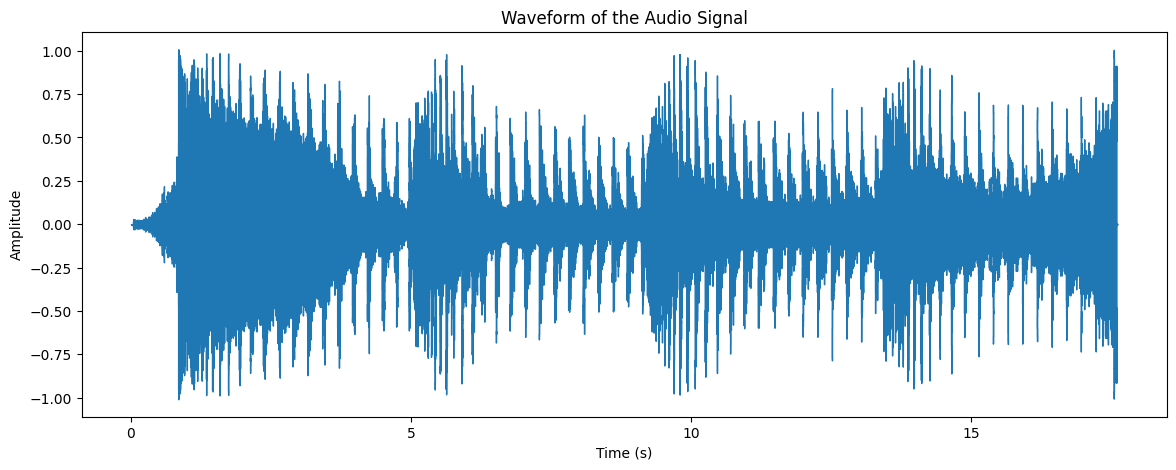

In [20]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Load the audio file
audio_file = 'music1.mp3'
y, sr = librosa.load(audio_file)

# Plot the waveform
plt.figure(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr)

# Add title and labels
plt.title('Waveform of the Audio Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Display the plot
plt.show()


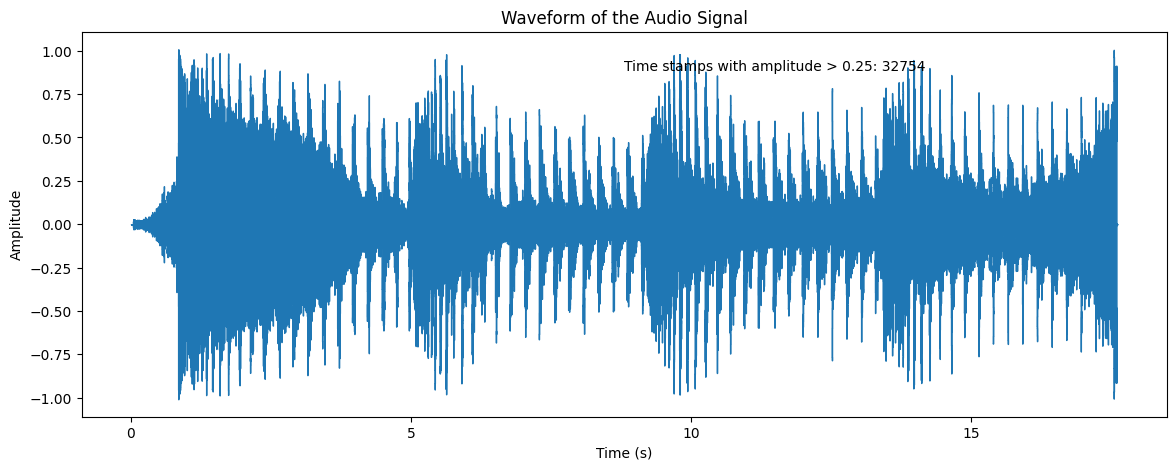

Time stamps where amplitude is above 0.25: [ 415.98548753  416.00870748  416.03192744 ... 9002.12099773 9002.14421769
 9002.16743764]


In [13]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Load the audio file
audio_file = 'music1.mp3'
y, sr = librosa.load(audio_file)

# Plot the waveform
plt.figure(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr)

# Add title and labels
plt.title('Waveform of the Audio Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Find timestamps where amplitude is above 0.25
threshold = 0.25
above_threshold = np.where(y > threshold)[0]
time_above_threshold = librosa.frames_to_time(above_threshold, sr=sr)

# Display count of timestamps with amplitude above 0.25
count_above_threshold = len(time_above_threshold)
plt.text(0.5, 0.9, f'Time stamps with amplitude > 0.25: {count_above_threshold}', transform=plt.gca().transAxes)

# Display the plot
plt.show()

# Print the details of time stamps
print("Time stamps where amplitude is above 0.25:", time_above_threshold)


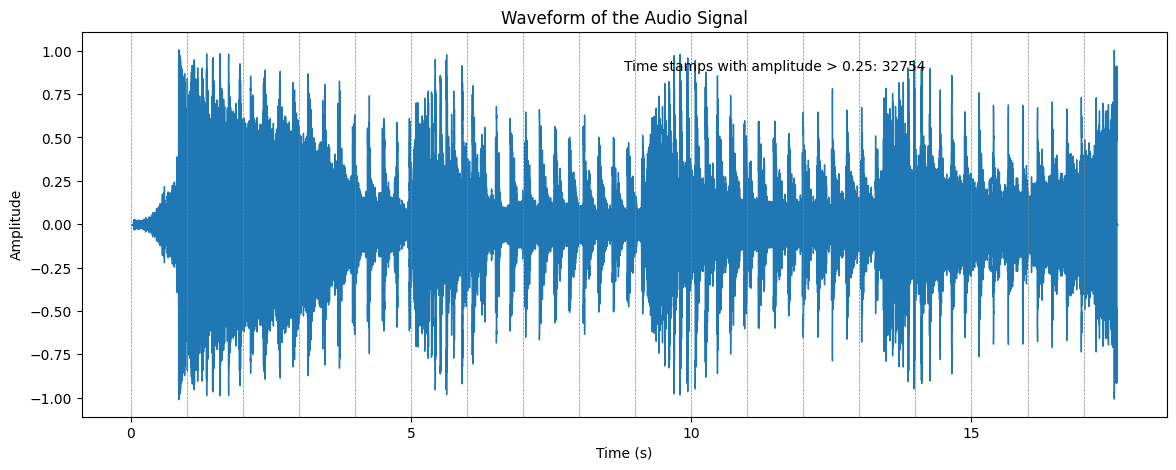

Time stamps where amplitude is above 0.25: [ 415.98548753  416.00870748  416.03192744 ... 9002.12099773 9002.14421769
 9002.16743764]


In [15]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Load the audio file
audio_file = 'music1.mp3'
y, sr = librosa.load(audio_file)

# Plot the waveform
plt.figure(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr)

# Add title and labels
plt.title('Waveform of the Audio Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Find timestamps where amplitude is above 0.25
threshold = 0.25
above_threshold = np.where(y > threshold)[0]
time_above_threshold = librosa.frames_to_time(above_threshold, sr=sr)

# Display count of timestamps with amplitude above 0.25
count_above_threshold = len(time_above_threshold)
plt.text(0.5, 0.9, f'Time stamps with amplitude > 0.25: {count_above_threshold}', transform=plt.gca().transAxes)

# Plot time labels at each 1 second
total_duration = librosa.get_duration(y=y, sr=sr)
interval = 1
for i in np.arange(0, total_duration, interval):
    plt.axvline(x=i, color='gray', linestyle='--', linewidth=0.5)

# Display the plot
plt.show()

# Print the details of time stamps
print("Time stamps where amplitude is above 0.25:", time_above_threshold)


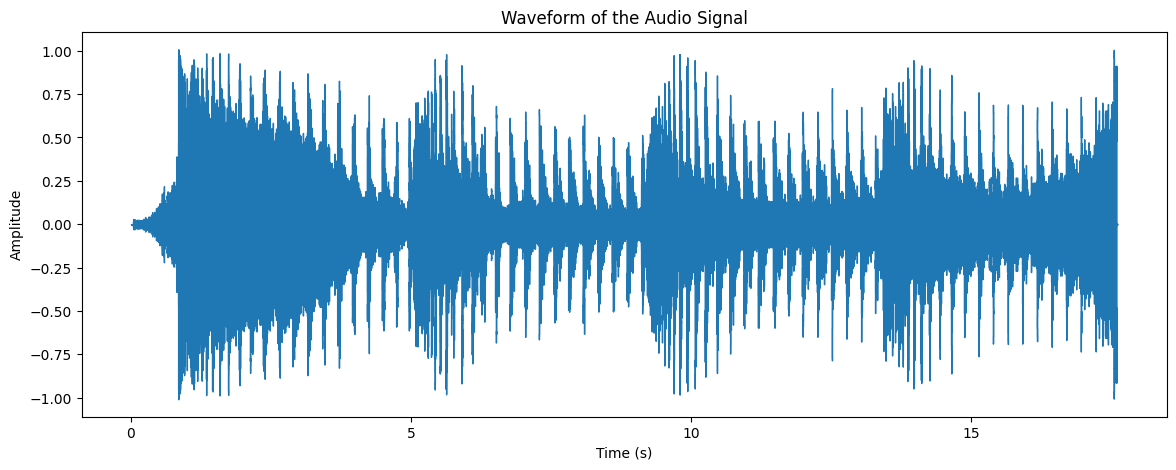

Peaks for threshold 0.75: [ 431.49641723  431.58929705  431.72861678  431.77505669  431.8214966
  432.3323356   432.47165533  432.54131519  432.68063492  432.75029478
  434.42213152  434.49179138  434.56145125  434.74721088  434.88653061
  435.04907029  435.0955102   435.16517007  435.28126984  436.8370068
  436.92988662  440.13424036  440.20390023  440.29678005  440.34321995
  440.41287982  440.48253968  440.55219955  440.62185941  440.71473923
  440.76117914  440.90049887  440.97015873  441.0862585   441.13269841
  441.22557823  441.31845805  445.0800907   445.26585034  445.31229025
  445.40517007  445.45160998  445.5444898   445.66058957  445.70702948
  445.75346939  445.82312925  445.96244898  446.03210884  446.14820862
  446.19464853  446.28752834  446.35718821  446.49650794  446.72870748
  451.25659864  451.39591837  451.5352381   451.62811791  451.7906576
  451.86031746  451.92997732  451.97641723  452.09251701  452.25505669
  458.2922449   458.38512472  458.50122449  458.594104

In [16]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks

# Load the audio file
audio_file = 'music1.mp3'
y, sr = librosa.load(audio_file)

# Plot the waveform
plt.figure(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr)

# Add title and labels
plt.title('Waveform of the Audio Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Extract peaks for different amplitude thresholds
thresholds = [0.75, 0.50, 0.75, 0.50, 0.75, 0.50, 0.75, 0.50]
peaks = []

for threshold in thresholds:
    # Find peaks above the threshold
    peak_indices, _ = find_peaks(y, height=threshold)
    
    # Convert peak indices to time
    peaks.append(librosa.frames_to_time(peak_indices, sr=sr))

# Display the plot
plt.show()

# Print the details of peaks
for i, peak_times in enumerate(peaks):
    print(f"Peaks for threshold {thresholds[i]}: {peak_times}")


Count of peaks for threshold 0.75: 237
Count of peaks for threshold 0.5: 1307
Count of peaks for threshold 0.75: 237
Count of peaks for threshold 0.5: 1307
Count of peaks for threshold 0.75: 237
Count of peaks for threshold 0.5: 1307
Count of peaks for threshold 0.75: 237
Count of peaks for threshold 0.5: 1307


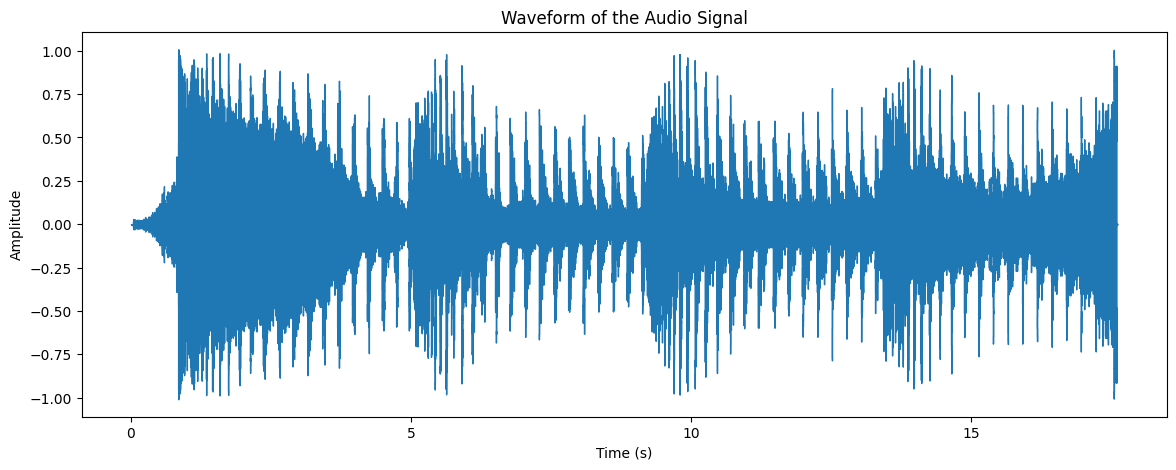

Peaks for threshold 0.75: [ 431.49641723  431.58929705  431.72861678  431.77505669  431.8214966
  432.3323356   432.47165533  432.54131519  432.68063492  432.75029478
  434.42213152  434.49179138  434.56145125  434.74721088  434.88653061
  435.04907029  435.0955102   435.16517007  435.28126984  436.8370068
  436.92988662  440.13424036  440.20390023  440.29678005  440.34321995
  440.41287982  440.48253968  440.55219955  440.62185941  440.71473923
  440.76117914  440.90049887  440.97015873  441.0862585   441.13269841
  441.22557823  441.31845805  445.0800907   445.26585034  445.31229025
  445.40517007  445.45160998  445.5444898   445.66058957  445.70702948
  445.75346939  445.82312925  445.96244898  446.03210884  446.14820862
  446.19464853  446.28752834  446.35718821  446.49650794  446.72870748
  451.25659864  451.39591837  451.5352381   451.62811791  451.7906576
  451.86031746  451.92997732  451.97641723  452.09251701  452.25505669
  458.2922449   458.38512472  458.50122449  458.594104

In [17]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks

# Load the audio file
audio_file = 'music1.mp3'
y, sr = librosa.load(audio_file)

# Plot the waveform
plt.figure(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr)

# Add title and labels
plt.title('Waveform of the Audio Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Extract peaks for different amplitude thresholds
thresholds = [0.75, 0.50, 0.75, 0.50, 0.75, 0.50, 0.75, 0.50]
peaks = []

for threshold in thresholds:
    # Find peaks above the threshold
    peak_indices, _ = find_peaks(y, height=threshold)
    
    # Convert peak indices to time
    peak_times = librosa.frames_to_time(peak_indices, sr=sr)
    
    # Append peak times to the list
    peaks.append(peak_times)
    
    # Print the count of peaks
    print(f"Count of peaks for threshold {threshold}: {len(peak_times)}")

# Display the plot
plt.show()

# Print the details of peaks
for i, peak_times in enumerate(peaks):
    print(f"Peaks for threshold {thresholds[i]}: {peak_times}")


Count of peaks for segment 1: 579
Count of peaks for segment 2: 169
Count of peaks for segment 3: 133
Count of peaks for segment 4: 6
Count of peaks for segment 5: 150
Count of peaks for segment 6: 21
Count of peaks for segment 7: 92
Count of peaks for segment 8: 157
Peaks for segment 1: [ 431.49641723  431.58929705  431.72861678  431.77505669  431.8214966
  431.93759637  432.3323356   432.47165533  432.54131519  432.68063492
  432.75029478  432.86639456  434.28281179  434.42213152  434.49179138
  434.56145125  434.74721088  434.88653061  435.04907029  435.0955102
  435.16517007  435.28126984  436.62802721  436.8370068   436.92988662
  437.16208617  437.20852608  440.13424036  440.20390023  440.29678005
  440.34321995  440.41287982  440.48253968  440.55219955  440.62185941
  440.71473923  440.76117914  440.90049887  440.97015873  441.0862585
  441.13269841  441.22557823  441.31845805  441.5506576   441.66675737
  445.0800907   445.26585034  445.31229025  445.40517007  445.45160998
  44

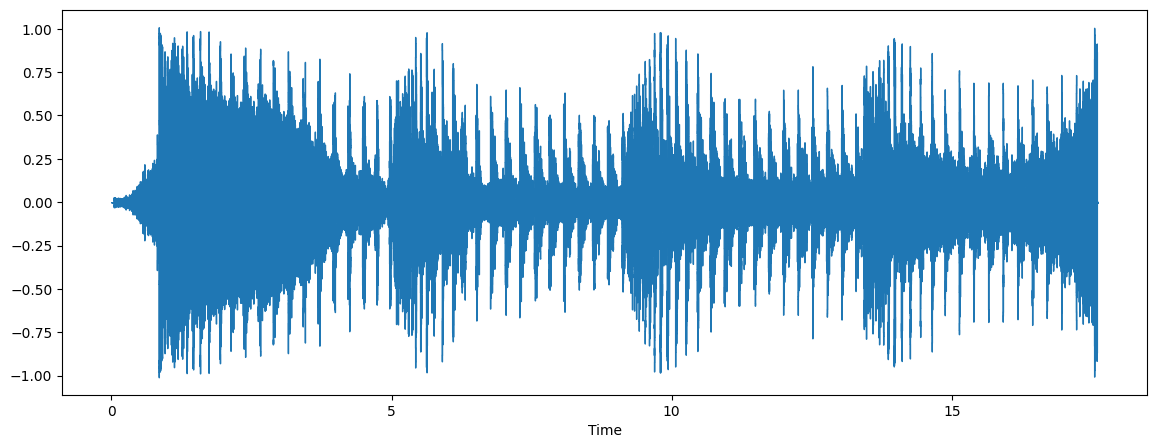

In [18]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks

# Load the audio file
audio_file = 'music1.mp3'
y, sr = librosa.load(audio_file)

# Divide the audio into 8 equal segments
num_segments = 8
segment_duration = len(y) // num_segments

# Initialize a list to store peaks for each segment
segment_peaks = []

# Iterate over segments
for i in range(num_segments):
    # Extract the current segment
    segment = y[i * segment_duration : (i + 1) * segment_duration]

    # Find peaks above the threshold for the current segment
    threshold = 0.5  # You can adjust this threshold as needed
    peak_indices, _ = find_peaks(segment, height=threshold)
    
    # Convert peak indices to time for the current segment
    peak_times = librosa.frames_to_time(peak_indices, sr=sr) + i * (len(y) / sr)

    # Append peak times to the list for each segment
    segment_peaks.append(peak_times)

    # Print the count of peaks for the current segment
    print(f"Count of peaks for segment {i+1}: {len(peak_times)}")

# Display the plot
plt.figure(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr)

# Print the details of peaks for each segment
for i, peak_times in enumerate(segment_peaks):
    print(f"Peaks for segment {i+1}: {peak_times}")

plt.show()


Count of peaks for segment 1: 579
Count of peaks for segment 2: 169
Count of peaks for segment 3: 133
Count of peaks for segment 4: 6
Count of peaks for segment 5: 150
Count of peaks for segment 6: 21
Count of peaks for segment 7: 92
Count of peaks for segment 8: 157
Showing 5790 images for segment 1
Showing 1690 images for segment 2
Showing 1330 images for segment 3
Showing 60 images for segment 4
Showing 1500 images for segment 5
Showing 210 images for segment 6
Showing 920 images for segment 7
Showing 1570 images for segment 8


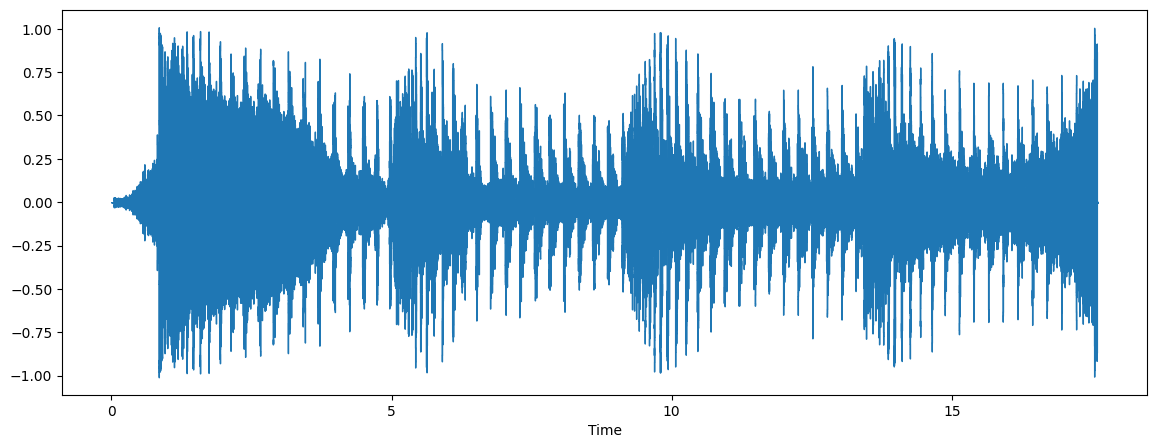

In [19]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks

# Load the audio file
audio_file = 'music1.mp3'
y, sr = librosa.load(audio_file)

# Divide the audio into 8 equal segments
num_segments = 8
segment_duration = len(y) // num_segments

# Initialize a list to store peaks for each segment
segment_peaks = []

# Iterate over segments
for i in range(num_segments):
    # Extract the current segment
    segment = y[i * segment_duration : (i + 1) * segment_duration]

    # Find peaks above the threshold for the current segment
    threshold = 0.5  # You can adjust this threshold as needed
    peak_indices, _ = find_peaks(segment, height=threshold)
    
    # Convert peak indices to time for the current segment
    peak_times = librosa.frames_to_time(peak_indices, sr=sr) + i * (len(y) / sr)

    # Append peak times to the list for each segment
    segment_peaks.append(peak_times)

    # Print the count of peaks for the current segment
    print(f"Count of peaks for segment {i+1}: {len(peak_times)}")

# Display the plot
plt.figure(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr)

# Set the scaling factor for image frequency
scaling_factor = 10

# Show images based on peak counts
for i, peak_times in enumerate(segment_peaks):
    image_frequency = int(len(peak_times) * scaling_factor)
    print(f"Showing {image_frequency} images for segment {i+1}")

    # Here you can insert code to display images or perform any action based on the image frequency

plt.show()


In [ ]:
import os
import cv2
import librosa
import numpy as np
from scipy.signal import find_peaks

# Load the audio file
audio_file = 'music1.mp3'
y, sr = librosa.load(audio_file)

# Divide the audio into 8 equal segments
num_segments = 8
segment_duration = len(y) // num_segments

# Initialize a list to store peaks for each segment
segment_peaks = []

# Iterate over segments
for i in range(num_segments):
    # Extract the current segment
    segment = y[i * segment_duration: (i + 1) * segment_duration]

    # Find peaks above the threshold for the current segment
    threshold = 0.5  # You can adjust this threshold as needed
    peak_indices, _ = find_peaks(segment, height=threshold)

    # Convert peak indices to time for the current segment
    peak_times = librosa.frames_to_time(peak_indices, sr=sr) + i * (len(y) / sr)

    # Append peak times to the list for each segment
    segment_peaks.append(peak_times)

    # Print the count of peaks for the current segment
    print(f"Count of peaks for segment {i + 1}: {len(peak_times)}")

# Set the scaling factor for image frequency
scaling_factor = 10

# Set the path to your images folder
images_folder = 'images'

# Create a list to store images
images = []

# Read images from the folder
for filename in os.listdir(images_folder):
    img_path = os.path.join(images_folder, filename)
    img = cv2.imread(img_path)
    images.append(img)

# Create a video writer
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video_output = cv2.VideoWriter('output_video.mp4', fourcc, 1, (images[0].shape[1], images[0].shape[0]))

# Show images based on peak counts
for i, peak_times in enumerate(segment_peaks):
    image_frequency = int(len(peak_times) * scaling_factor)
    print(f"Showing {image_frequency} images for segment {i + 1}")

    # Here you can insert code to display images or perform any action based on the image frequency
    for j in range(image_frequency):
        # Write the image to the video
        video_output.write(images[j % len(images)])

# Release the video writer
video_output.release()


Count of peaks for segment 1: 579
Count of peaks for segment 2: 169
Count of peaks for segment 3: 133
Count of peaks for segment 4: 6
Count of peaks for segment 5: 150
Count of peaks for segment 6: 21
Count of peaks for segment 7: 92
Count of peaks for segment 8: 157
Showing 5790 images for segment 1
